## Identifying good movies from IMDB 

This project will focus on identifying good movies from a random sample of movies from IMDB. The definition of a 'good movie' in this case depends on the IMDB rating of a movie. The threshold value for a good movie will be defined later in the project, as it depends on the distribution of movie ratings on IMDB. However, the aim will be to correctly identify the top 25% of movies. This project will be considered succesful if it increases the baseline accuracy of identifying good movies. 

As features, this project uses information that is independent of ratings to try and predict whether a movie will be succesful. An easy way to determine if a movie is good would be by looking at the reviews, but since these are only known after the movie is released (and correlate highly with movie ratings), this project tries to look at other features (such as the genre, whether or not the movie has a tagline, the actors, directors, and the outline of the plot).

The project will use machine learning models such as decision trees and random forests to try to maximize the accuracy of the prediction of good movies using the features described earlier. 

In [ ]:
import pandas as pd
import numpy as np
from imdbpie import Imdb

In [ ]:
imdb = Imdb()
imdb = Imdb(anonymize=True)

In [ ]:
df = pd.DataFrame

## Data collection

To get a random sample, IMDB is scraped using a random ID generator. These ID's follow a pattern, in which higher ID values represent more recent additions to the database. More recent additions, however, tend to be TV episodes or TV shows. To get features efficiently, the first random integer only has a range of 0 to 4 (this means the probability of the ID corresponding with a movie is much higher, but the movies identified will tend to be older).

In [ ]:
#movie_count = 0 
movie_count = 256
# for i in range(10000):
for i in range(2786, 10000):
    id_ = 'tt'+str(0)+str(np.random.randint(0,4))+''.join(["%s" % np.random.randint(0, 9) for num in range(5)])
    print id_
    if imdb.title_exists(id_):
        try:
            title = imdb.get_title_by_id(id_)
            if title.type=='feature':
                if title.plot_outline!=None:
                    df.loc[i,'rating']=title.rating
                    df.loc[i,'title']=title.title
                    df.loc[i,'year']=title.year
                    for z in range(len(title.directors_summary)):
                        df.loc[i, 'director'+str(z)]=str(title.directors_summary[z]).rsplit("'")[1]
                    df.loc[i, 'runtime']= title.runtime
                    for y in range(len(title.genres)):
                        df.loc[i, 'genres'+str(y)]=title.genres[y]
                    for x in range(len(title.cast_summary)):
                        df.loc[i, 'actor' +str(x)]= str(title.cast_summary[x]).rsplit("'")[1]
                    df.loc[i, 'tagline']= title.tagline
                    df.loc[i, 'outline']= title.plot_outline
                    movie_count+=1
                    print movie_count
                    if movie_count == 500:
                        break
                else:
                    pass
            else:
                pass
        except:
            pass
    
print df

We have scraped 515 features in the dataset, all of which are selected to have a plot outline. However, the dataframe info below shows that not all of the movies have ratings. The data will need some further cleaning.

In [ ]:
df.info()

In [ ]:
df.to_csv('initial_scrape.csv', sep=';', encoding ='utf-8')

In [2]:
import pandas as pd
import numpy as np
from imdbpie import Imdb
from __future__ import division

In [3]:
df = pd.read_csv('initial_scrape.csv', sep =';', encoding = 'utf-8')

## Data cleaning

In [4]:
(df['title'].value_counts()).head()

Madrid en el año 2000                                 2
Sette ore di violenza per una soluzione imprevista    2
Wrony                                                 2
The Far Frontier                                      1
Any Place But Home                                    1
Name: title, dtype: int64

We can also identify some duplicate values in our database, since there is some overlap caused by the random ID generator. We remove these duplicates.

In [5]:
df = df.drop_duplicates('title')

In [6]:
(df['title'].value_counts()).head()

Mera Yaar Mera Dushman                  1
Schwarz und weiß wie Tage und Nächte    1
Any Place But Home                      1
Rock You Sinners                        1
The Child and the Soldier               1
Name: title, dtype: int64

In [7]:
df = df.drop('Unnamed: 0', axis=1)

Rows that have missing values in the rating, runtime, or primary genre columns are dropped from the dataframe.

In [8]:
df = df[pd.notnull(df['rating'])]
df = df[pd.notnull(df['runtime'])]
df = df[pd.notnull(df['genres0'])]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406 entries, 0 to 514
Data columns (total 19 columns):
rating       406 non-null float64
title        406 non-null object
year         406 non-null float64
director0    406 non-null object
runtime      406 non-null float64
genres0      406 non-null object
actor0       406 non-null object
actor1       406 non-null object
actor2       404 non-null object
actor3       403 non-null object
tagline      171 non-null object
outline      406 non-null object
genres1      242 non-null object
genres2      110 non-null object
genres3      50 non-null object
director1    19 non-null object
genres4      8 non-null object
genres5      3 non-null object
genres6      1 non-null object
dtypes: float64(3), object(16)
memory usage: 63.4+ KB


In [10]:
df.describe()

,rating,year,runtime
count,406.000000,406.000000,406.000000
mean,6.084729,1972.034483,5529.014778
std,1.225778,22.907518,1363.165711
min,1.500000,1914.000000,2820.000000
25%,5.400000,1955.000000,4740.000000
50%,6.300000,1974.000000,5460.000000
75%,6.900000,1994.000000,6000.000000
max,9.000000,2004.000000,12600.000000


In [11]:
df = df.reset_index(drop=True)

## Defining the target variable

The 75th percentile for movie ratings in the sample created randomly from the IMDB database has a value of 6,9. This leads to a natural threshold value to determine whether a movie is good or not: a movie that has a rating of 7 or higher will be a good movie, while any movie that has a rating below 7 will not be considered a good movie.

In [12]:
for i in range(len(df['rating'])):
    if df.loc[i, 'rating']<7:
        df.loc[i, 'good_movie'] =0
    else:
        df.loc[i, 'good_movie'] =1

Of the 406 movies, 308 are not considered to be good movies. 98 of them turn out to be good movies. This leads to a baseline of 0.759.

In [13]:
df['good_movie'].value_counts()

0.0    308
1.0     98
Name: good_movie, dtype: int64

In [14]:
print 'Baseline:'
print 308/406

Baseline:
0.758620689655


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

## Visualizations

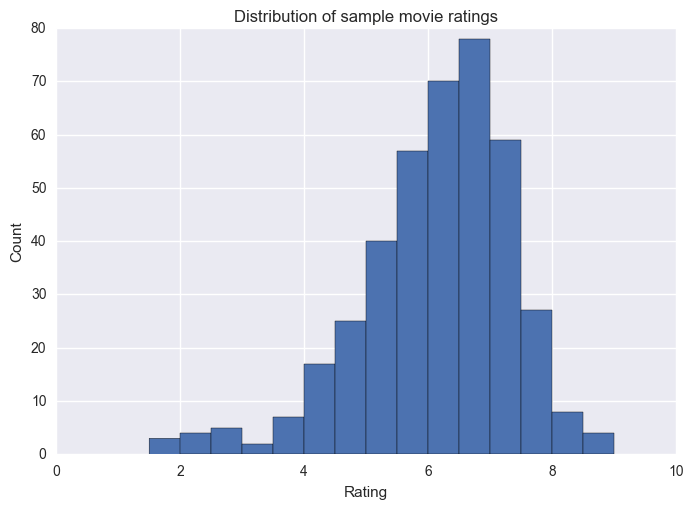

In [16]:
plt.hist(df['rating'], bins=(15))
plt.xlim(0,10)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of sample movie ratings')
plt.show()

The distribution of ratings seems to be negatively skewed. The mean is lower than the median, which is lower than the mode. The cutoff point for being a good movie in this project is a rating of 7.

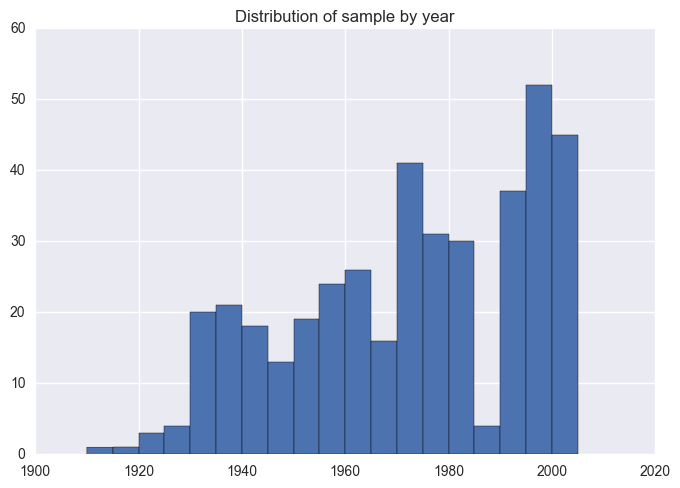

In [17]:
plt.hist(df['year'], bins =range(1910,2010, 5))
plt.title("Distribution of sample by year")
plt.show()

As can be seen from this chart, recent movies (movies after 2004) are not included in the sample. What is also interesting is that there seem to be relatively few movies in our dataset that were released in the time period 1985-1989.

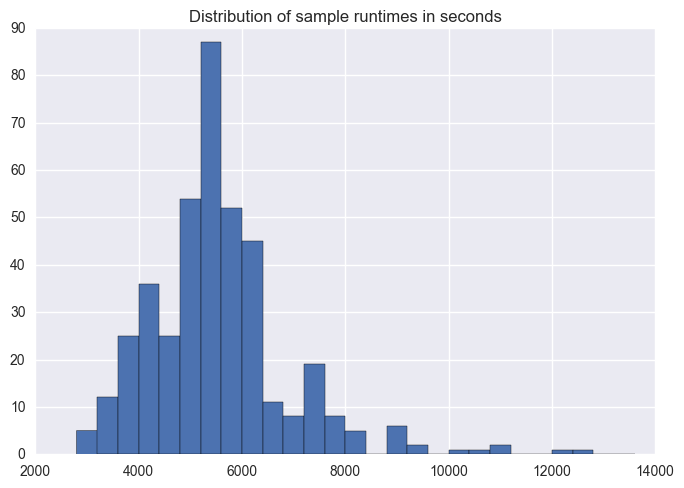

In [18]:
plt.hist(df['runtime'], bins =range(2800, 14000, 400))
plt.title("Distribution of sample runtimes in seconds")
plt.show()

There are a few large outliers in the dataset (movies that last longer than 12000 seconds which is almost 3,5 hours). The average movie seems to last a little over half an hour.

## Defining the features to be used in the analysis.

In [19]:
for i in range(len(df['tagline'])):
    if pd.isnull(df['tagline'])[i]:
        df.loc[i, 'has_tagline']=0
    else:
        df.loc[i, 'has_tagline']=1

One of the features to predict whether a movie will be good or not, is to see whether the movie has a tagline or not. This may have predictive power for defining whether a movie will be good or not.

In [20]:
for i in range(len(df['director1'])):
    if pd.isnull(df['director1'])[i]:
        df.loc[i, 'mult_directors']=0
    else:
        df.loc[i, 'mult_directors']=1

Another feature that is created is a dummy for movies that have multiple directors. This might lead to better movies.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=50, stop_words='english')
data = cv.fit_transform(df.outline).todense()
columns = [c for c in cv.get_feature_names()]
outlinedf = pd.DataFrame(data, columns=columns)
outlinedf.columns = ['out_' + str(col) for col in outlinedf.columns]
outlinedf.head()

,out_american,out_boy,out_business,out_city,out_daughter,out_day,out_death,out_doctor,out_family,out_father,...,out_war,out_wealthy,out_wife,out_woman,out_women,out_world,out_writer,out_year,out_years,out_young
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,2,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0


The outline may have a certain predictive power for the success of a movie: certain words in an outline may predict that a movie will have a better rating.

In [23]:
genre1 = pd.get_dummies(df.loc[:,'genres0'], prefix = 'gen_')
genre2 = pd.get_dummies(df.loc[:,'genres1'], prefix = 'gen_')
genre3 = pd.get_dummies(df.loc[:,'genres2'], prefix = 'gen_')
genre4 = pd.get_dummies(df.loc[:,'genres3'], prefix = 'gen_')
genre12 = genre1.add(genre2, fill_value=0)
genre123 = genre12.add(genre3, fill_value = 0)
genre = genre123.add(genre4, fill_value = 0)

The genre of a movie may also determine whether a movie will receive a good rating or not.

In [24]:
df_new = df.join(outlinedf)
df_new = df_new.join(genre)

In [25]:
df_new = df_new.drop(df.loc[:,'genres0':'genres6'], axis=1)
df_new = df_new.drop('director0', axis=1)

In [26]:
y = df_new['good_movie']

In [27]:
X = df_new.loc[:, 'year':]
X = X.drop('good_movie', axis=1)

Finally, all of the features selected are scaled, to make sure that they are treated equally and that the model does not misinterpret the size and significance of different feature values.

In [28]:
from sklearn.preprocessing import StandardScaler
X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)

In [29]:
X.head()

,year,runtime,has_tagline,mult_directors,out_american,out_boy,out_business,out_city,out_daughter,out_day,...,gen__Horror,gen__Music,gen__Musical,gen__Mystery,gen__Romance,gen__Sci-Fi,gen__Sport,gen__Thriller,gen__War,gen__Western
0,-1.618690,-0.799872,-0.853030,-0.221575,-0.18357,-0.15891,-0.150566,-0.153177,-0.166878,-0.150566,...,-0.330590,-0.132453,-0.181876,-0.256158,-0.428571,-0.245056,-0.122474,-0.374766,-0.20905,-0.27735
1,1.134892,-0.447316,1.172292,-0.221575,-0.18357,-0.15891,-0.150566,-0.153177,-0.166878,-0.150566,...,3.024897,-0.132453,-0.181876,-0.256158,-0.428571,-0.245056,-0.122474,-0.374766,-0.20905,-0.27735
2,-0.438584,-0.182899,-0.853030,-0.221575,-0.18357,-0.15891,-0.150566,-0.153177,-0.166878,-0.150566,...,-0.330590,-0.132453,-0.181876,-0.256158,-0.428571,-0.245056,-0.122474,-0.374766,-0.20905,-0.27735
3,-0.831953,-0.491386,-0.853030,-0.221575,-0.18357,-0.15891,-0.150566,5.500454,-0.166878,-0.150566,...,-0.330590,-0.132453,-0.181876,-0.256158,-0.428571,-0.245056,-0.122474,2.668333,-0.20905,-0.27735
4,0.828938,0.037448,-0.853030,-0.221575,-0.18357,-0.15891,-0.150566,-0.153177,-0.166878,-0.150566,...,-0.330590,-0.132453,-0.181876,-0.256158,-0.428571,-0.245056,-0.122474,-0.374766,-0.20905,-0.27735


The sample is split into a testing sample and a training set, so that there is no information spillover and so that there is a fair assessment of the accuracy of the model.

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

To start off, we use decision tree classifiers to look into our classification problem. 

In [31]:
from sklearn.tree import DecisionTreeClassifier
treereg = DecisionTreeClassifier()
treereg.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [32]:
preds = treereg.predict(X_test)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
print classification_report(y_test, preds)

             precision    recall  f1-score   support

        0.0       0.77      0.84      0.80        89
        1.0       0.42      0.30      0.35        33

avg / total       0.67      0.70      0.68       122



The decision tree leads to a fairly poor score compared to our baseline accuracy, indicating that the features do not have a lot of predictive power.

In [39]:
print confusion_matrix(y_test, preds)

[[75 14]
 [23 10]]


In [40]:
from os import system
from sklearn.tree import export_graphviz
def build_tree_image(model, filename='tree.png'):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model, out_file = dotfile, feature_names = X.columns,filled=True,
                    rounded=True,special_characters=True)
    dotfile.close()
    system("dot -Tpng tree.dot -o {0}".format(filename))

In [41]:
build_tree_image(treereg,'tree1.png')

<img src='tree1.png' width= 80%>

In [42]:
from sklearn.model_selection import GridSearchCV
params = dict(max_depth=range(2,10), min_samples_split=range(2,10), max_features = (2,76))
gridsearch = GridSearchCV(estimator = treereg, param_grid = params)

In [43]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': (2, 76), 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [44]:
gridsearch.best_params_

{'max_depth': 6, 'max_features': 2, 'min_samples_split': 5}

In [45]:
gridsearch.best_score_

0.78169014084507038

In [46]:
treereg = DecisionTreeClassifier(max_depth= 6, max_features= 2, min_samples_split= 5)
treereg.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [47]:
y_pred = treereg.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [49]:
accuracy_score(y_test, y_pred)

0.72131147540983609

In [50]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

        0.0       0.73      0.99      0.84        89
        1.0       0.00      0.00      0.00        33

avg / total       0.53      0.72      0.61       122



In [51]:
print confusion_matrix(y_test, y_pred)

[[88  1]
 [33  0]]


In [53]:
build_tree_image(treereg,'tree2.png')

<img src='tree2.png' width= 80%>

In [54]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [55]:
rforest = RandomForestClassifier(n_estimators= 5)
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [56]:
y_forest = rforest.predict(X_test)

In [57]:
accuracy_score(y_test, y_forest)

0.65573770491803274

## Conclusion

The predictive power of the models used is pretty poor. In my view this can be explained by the random sample that I have selected, and the lack of predictive power of the features selected. Genre, runtime, words in an outline, the number of directors or whether the movie has a tagline do not seem to be able to predict whether a movie is succesful or not. Future projects should include better features. However, including reviews did not seem fair to me, since these are written as a response to the quality of a movie. So this means that even though it might be highly correlated with a movie rating, it has no predictive power to see whether a movie will be succesful or not. For future projects it would be better to use other features that are known before a movie is released (such as production value).